In [1]:
%pip install mplcyberpunk torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.3 MB/s eta 0:00:00


In [2]:
import torch
import torchvision

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torchmetrics import Accuracy
from tqdm.auto import tqdm

In [3]:
# check the version of torch and torchvision
print(torch.__version__, torchvision.__version__)

# setup device agnoustic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.8.0+cu126 0.23.0+cu126
cuda


### Loading, Exploring and Preparing the dataset

we are going to use FashionMNIST Dataset from torch vision

In [4]:
training_data = datasets.FashionMNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor()
)

testing_data = datasets.FashionMNIST(
  root="data",
  train=False,
  download=True,
  transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


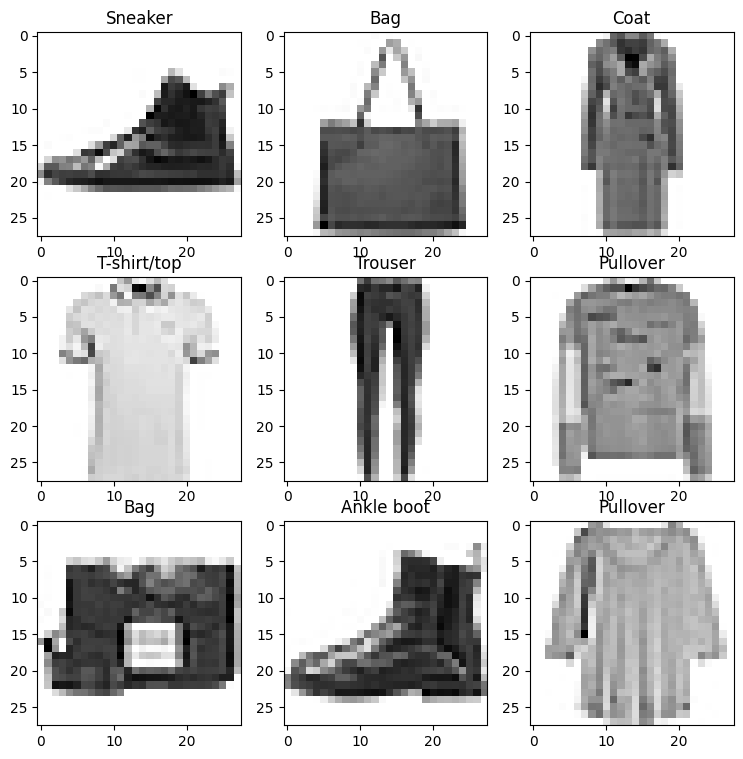

In [6]:
fig = plt.figure(figsize=(9, 9))

rows, cols = 3, 3

for i in range(1, rows * cols + 1):
  rand_idx = torch.randint(0, len(training_data), (1,)).item()
  fig.add_subplot(rows, cols, i)
  feat, label = training_data[rand_idx]
  plt.title(training_data.classes[label])
  plt.imshow(feat.squeeze(), cmap=plt.cm.gray_r)

In [7]:
from torch.utils.data import DataLoader
training_dataloader = DataLoader(dataset=training_data, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(dataset=testing_data, batch_size=32, shuffle=False)

In [8]:
len(training_data.classes)

10

In [9]:
class FashionModel(nn.Module):
  def __init__(self, hidden_layers = 10):
    super().__init__()

    self.seq = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=784, out_features=hidden_layers),
      nn.Linear(in_features=hidden_layers, out_features=10)
    )
  def forward(self, x):
    return self.seq(x)

In [26]:
model = FashionModel().to(device)

In [27]:
# setpup the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# loss function
loss_fn = torch.nn.CrossEntropyLoss()
# accuracy function
acc_fn = Accuracy(task='multiclass', num_classes=len(training_data.classes)).to(device)

In [29]:
epochs = 10

for epoch in tqdm(range(epochs)):

  avg_train_loss = 0
  avg_train_acc = 0

  avg_test_loss = 0
  avg_test_acc = 0

  for X_train, y_train in training_dataloader:

    X_train, y_train = X_train.to(device), y_train.to(device)
    # put the model in the training mode
    model.train()

    # do the forward pass
    logits = model(X_train)
    preds = torch.softmax(logits, dim=1).argmax(dim=1)
    # calculate the loss
    loss = loss_fn(logits, y_train)
    avg_train_loss += loss

    # calculate the accuracy
    acc = acc_fn(preds, y_train)
    avg_train_acc += acc

    # zero the optimizer gradients
    optimizer.zero_grad()
    # backpropagtion
    loss.backward()
    # step the optimizer
    optimizer.step()

  avg_train_loss /= len(training_dataloader)
  avg_train_acc /= len(training_dataloader)

  with torch.inference_mode():
    for X_test, y_test in testing_dataloader:

      X_test, y_test = X_test.to(device), y_test.to(device)
      # do the testing phase
      model.eval()

      # activate the inference context
      test_logits = model(X_test)
      test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # calculate the test loss
      test_loss = loss_fn(test_logits, y_test)
      avg_test_loss += test_loss
      # calculate the test acc
      test_acc = acc_fn(test_preds, y_test)
      avg_test_acc += test_acc

    avg_test_loss /= len(testing_dataloader)
    avg_test_acc /= len(testing_dataloader)

    print(f"Epoch: {epoch}, loss: {avg_train_acc:0.4f}, acc: {avg_train_acc:0.2f} | test_loss: {avg_test_loss:0.4f}, test_acc: {avg_test_acc:0.4f}")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, loss: 0.8250, acc: 0.82 | test_loss: 0.5235, test_acc: 0.8176
Epoch: 1, loss: 0.8335, acc: 0.83 | test_loss: 0.5032, test_acc: 0.8225
Epoch: 2, loss: 0.8395, acc: 0.84 | test_loss: 0.4967, test_acc: 0.8257
Epoch: 3, loss: 0.8428, acc: 0.84 | test_loss: 0.4780, test_acc: 0.8313
Epoch: 4, loss: 0.8471, acc: 0.85 | test_loss: 0.4765, test_acc: 0.8324
Epoch: 5, loss: 0.8493, acc: 0.85 | test_loss: 0.4677, test_acc: 0.8351
Epoch: 6, loss: 0.8513, acc: 0.85 | test_loss: 0.4743, test_acc: 0.8321
Epoch: 7, loss: 0.8532, acc: 0.85 | test_loss: 0.4654, test_acc: 0.8348
Epoch: 8, loss: 0.8537, acc: 0.85 | test_loss: 0.4648, test_acc: 0.8332
Epoch: 9, loss: 0.8562, acc: 0.86 | test_loss: 0.4533, test_acc: 0.8396
